# Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import h5py
import obspy
from obspy.geodetics import gps2dist_azimuth
from obspy import UTCDateTime
import seisbench.models as sbm

import torch

# Load the model

In [43]:
# Initialize the model
model = sbm.PhaseNet(phases="PSN", norm="peak")

# Import weights from pretrained model
model.load_state_dict(torch.load("output/phasenet_weights.pth", map_location="cpu"))
model.eval()

/var/folders/w8/1z9zcf6n61b4xlr7r18jckm40000gn/T/ipykernel_37510/3733995580.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("output/phas

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [54]:
# Read the raw data and metadata
explosions = pd.read_csv("data/metadata.csv")
f = h5py.File("data/waveforms.hdf5", "r")


# Define localization algorithms

In [ ]:
# Define a basic grid search for the initial location
def initial_approximation(events, lat_range, lon_range, grid_size, vp=6.0, vs=3.5):
    """
    Performs a grid search to find an initial approximate earthquake location and origin time.

    Args:
        events (pd.DataFrame): DataFrame containing event data, including station locations,
                               arrival times, and source depth. Expected columns:
                               'station_latitude_deg', 'station_longitude_deg', 
                               'station_elevation_m', 'source_depth_km',
                               'trace_P_arrival_sample', 'trace_sampling_rate_hz',
                               'trace_S_arrival_sample'.
        lat_range (tuple): Tuple (min_lat, max_lat) for the latitude grid search.
        lon_range (tuple): Tuple (min_lon, max_lon) for the longitude grid search.
        grid_size (int): Number of points to use in each dimension of the grid.
        vp (float, optional): P-wave velocity in km/s. Defaults to 6.0.
        vs (float, optional): S-wave velocity in km/s. Defaults to 3.5.

    Returns:
        tuple: A tuple containing:
            - best_location (tuple): (latitude, longitude) of the best-fitting location.
            - best_t0 (float): Estimated origin time (t0_star) for the best location.
            - min_error (float): The minimum sum of squared residuals for the best location.
    """
    min_lat, max_lat = lat_range
    min_lon, max_lon = lon_range
    
    lat_grid = np.linspace(min_lat, max_lat, grid_size)
    lon_grid = np.linspace(min_lon, max_lon, grid_size)
    
    best_location = None
    best_t0 = None
    min_error = float('inf')
    
    station_lats   = events['station_latitude_deg'].values
    station_lons   = events['station_longitude_deg'].values
    station_elev_m = events['station_elevation_m'].values  
    
    station_elev_km = station_elev_m / 1000.0

    source_depth_km = events['source_depth_km'].iloc[0]

    p_arrivals = (
        events['trace_P_arrival_sample'].values
        / events['trace_sampling_rate_hz'].values
    )
    s_arrivals = (
        events['trace_S_arrival_sample'].values
        / events['trace_sampling_rate_hz'].values
    )
    
    for lat in lat_grid:
        for lon in lon_grid:
            dist_3d_list = []
            for (st_lat, st_lon, st_elev) in zip(station_lats, station_lons, station_elev_km):
                dist_m, _, _ = gps2dist_azimuth(lat, lon, st_lat, st_lon)
                dist_km = dist_m / 1000.0

                dist_3d = np.sqrt(dist_km**2 + (source_depth_km + st_elev)**2)
                dist_3d_list.append(dist_3d)

            dist_3d_list = np.array(dist_3d_list)
            
            p_travel_times = dist_3d_list / vp
            s_travel_times = dist_3d_list / vs
            
            p_res = p_arrivals - p_travel_times
            s_res = s_arrivals - s_travel_times
            combined_res = np.concatenate([p_res, s_res])
            t0_star = combined_res.mean()
            
            p_residuals = t0_star + p_travel_times - p_arrivals
            s_residuals = t0_star + s_travel_times - s_arrivals
            total_error = np.sum(p_residuals**2) + np.sum(s_residuals**2)
            
            if total_error < min_error:
                min_error = total_error
                best_location = (lat, lon)
                best_t0 = t0_star
    
    return best_location, best_t0, min_error

# Implement iterative earthquake location refinement technique used in seismology
def predicted_ddiff(lat, lon, event_i, event_j, velocity_p, velocity_s):
    """
    Calculates the predicted travel time double-difference for a pair of events (stations)
    given a hypocenter location and P and S wave velocities.

    Args:
        lat (float): Latitude of the trial hypocenter.
        lon (float): Longitude of the trial hypocenter.
        event_i (pd.Series): DataFrame row for the first event/station record.
                             Expected columns: 'station_latitude_deg', 
                             'station_longitude_deg', 'station_elevation_m', 
                             'source_depth_km'.
        event_j (pd.Series): DataFrame row for the second event/station record.
                             Expected columns: 'station_latitude_deg', 
                             'station_longitude_deg', 'station_elevation_m', 
                             'source_depth_km'.
        velocity_p (float): P-wave velocity in km/s.
        velocity_s (float): S-wave velocity in km/s.

    Returns:
        float: The sum of predicted P-wave and S-wave travel time differences 
               (tp_diff + ts_diff).
    """
    dist_i_m, _, _ = gps2dist_azimuth(
        lat, lon,
        event_i['station_latitude_deg'],
        event_i['station_longitude_deg']
    )
    dist_i_km = dist_i_m / 1000.0
    station_elev_i_km = event_i['station_elevation_m'] / 1000.0
    depth_i_km = event_i['source_depth_km']

    dist_3d_i = np.sqrt(
        dist_i_km**2 + (depth_i_km + station_elev_i_km)**2
    )

    dist_j_m, _, _ = gps2dist_azimuth(
        lat, lon,
        event_j['station_latitude_deg'],
        event_j['station_longitude_deg']
    )
    dist_j_km = dist_j_m / 1000.0
    station_elev_j_km = event_j['station_elevation_m'] / 1000.0
    depth_j_km = event_j['source_depth_km']

    dist_3d_j = np.sqrt(
        dist_j_km**2 + (depth_j_km + station_elev_j_km)**2
    )

    tp_diff = (dist_3d_i - dist_3d_j) / velocity_p
    ts_diff = (dist_3d_i - dist_3d_j) / velocity_s

    return tp_diff + ts_diff


def double_difference(events, initial_guess, velocity_p, velocity_s,
                      max_iterations=20, tolerance=1e-5, step=1e-4):
    """
    Refines seismic event location using the double-difference algorithm.

    This function iteratively adjusts the latitude and longitude of an event's
    hypocenter to minimize the difference between observed and predicted
    travel-time differences between pairs of stations.

    Args:
        events (pd.DataFrame): DataFrame containing event data for multiple stations
                               recording the same earthquake. Expected columns:
                               'station_latitude_deg', 'station_longitude_deg',
                               'station_elevation_m', 'source_depth_km',
                               'trace_P_arrival_sample', 'trace_S_arrival_sample',
                               'trace_sampling_rate_hz', 
                               'trace_P_arrival_uncertainty_s',
                               'trace_S_arrival_uncertainty_s'.
        initial_guess (tuple): (latitude, longitude) of the initial hypocenter estimate.
        velocity_p (float): P-wave velocity in km/s.
        velocity_s (float): S-wave velocity in km/s.
        max_iterations (int, optional): Maximum number of iterations. Defaults to 20.
        tolerance (float, optional): Convergence tolerance for changes in lat/lon.
                                     Defaults to 1e-5.
        step (float, optional): Step size used for numerical differentiation.
                                Defaults to 1e-4.

    Returns:
        tuple: (latitude, longitude) of the refined hypocenter location.

    Raises:
        ValueError: If latitude goes out of bounds (-90 to 90 degrees).
    """
    lat, lon = initial_guess

    for iteration in range(max_iterations):
        A = []
        b = []

        for i, event_i in events.iterrows():
            for j, event_j in events.iterrows():
                if i >= j:
                    continue

                observed_p_diff = (event_i['trace_P_arrival_sample'] - event_j['trace_P_arrival_sample']) \
                                  / event_i['trace_sampling_rate_hz']
                observed_s_diff = (event_i['trace_S_arrival_sample'] - event_j['trace_S_arrival_sample']) \
                                  / event_i['trace_sampling_rate_hz']
                observed_ddiff = observed_p_diff + observed_s_diff

                predicted_dd = predicted_ddiff(lat, lon, event_i, event_j,
                                               velocity_p, velocity_s)

                residual = observed_ddiff - predicted_dd

                lat_plus = predicted_ddiff(lat + step, lon, event_i, event_j,
                                           velocity_p, velocity_s)
                lat_minus = predicted_ddiff(lat - step, lon, event_i, event_j,
                                            velocity_p, velocity_s)
                d_dlat = (lat_plus - lat_minus) / (2.0 * step)

                lon_plus = predicted_ddiff(lat, lon + step, event_i, event_j,
                                           velocity_p, velocity_s)
                lon_minus = predicted_ddiff(lat, lon - step, event_i, event_j,
                                            velocity_p, velocity_s)
                d_dlon = (lon_plus - lon_minus) / (2.0 * step)

                weight = 1.0 / (
                    event_i['trace_P_arrival_uncertainty_s']
                    + event_j['trace_P_arrival_uncertainty_s']
                    + event_i['trace_S_arrival_uncertainty_s']
                    + event_j['trace_S_arrival_uncertainty_s']
                )

                A.append([weight * d_dlat, weight * d_dlon])
                b.append(weight * residual)

        A = np.array(A)
        b = np.array(b)

        x_sol, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        d_lat, d_lon = x_sol

        lat_new = lat + d_lat
        lon_new = lon + d_lon

        if abs(d_lat) < tolerance and abs(d_lon) < tolerance:
            lat, lon = lat_new, lon_new
            print("Converged!")
            break

        lat, lon = lat_new, lon_new

        if not (-90 <= lat <= 90):
            raise ValueError(f"Latitude went out of bounds: {lat}")

    return lat, lon

# Select some event

In [ ]:
# Define some helper functions
def event_to_stream(event, datafile):
    bucket, narray = event['trace_name'].split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    data = datafile[f'/data/{bucket}'][x, :y, :z]

    channels = [
        'E',
        'N',
        'Z'
    ]

    stream = obspy.Stream()
    for i, c in enumerate(channels):
        tr = obspy.Trace()
        tr.data = data[i, :]
        tr.stats.event_id = event['event_id']
        tr.stats.event_time = event['source_origin_time']
        tr.stats.distance = gps2dist_azimuth(event['source_latitude_deg'], event['source_longitude_deg'], event['station_latitude_deg'], event['station_longitude_deg'])[0]
        tr.stats.network = event['station_network_code']
        tr.stats.station_code = event['station_code']
        tr.stats.station_network_code = event['station_network_code']
        tr.stats.sampling_rate = event['trace_sampling_rate_hz']
        tr.stats.starttime = UTCDateTime(event['trace_start_time'])
        tr.stats.station = event['station_network_code']
        tr.stats.location = event['station_location_code']
        tr.stats.station_latitude = event['station_latitude_deg']
        tr.stats.station_longitude = event['station_longitude_deg']
        tr.stats.channel = c

        stream.append(tr)
    return stream


def get_maximum_confidence_picks(classification):
    """
    Retrieves the picks with the highest confidence (peak value) for P and S phases.

    Args:
        classification: An object containing a list of picks with their associated
                        phase and peak value. Assumes `classification.picks` is iterable
                        and contains objects with `phase` and `peak_value` attributes.

    Returns:
        Tuple[Optional[Pick], Optional[Pick]]:
            - The pick with the highest confidence for the P phase (or None if no P picks are found).
            - The pick with the highest confidence for the S phase (or None if no S picks are found).
    """
    current_maxP_value = 0
    current_maxS_value = 0
    p_max = None
    s_max = None

    for pick in classification.picks:
        if pick.phase == "P":
            if pick.peak_value > current_maxP_value:
                current_maxP_value = pick.peak_value
                p_max = pick
        if pick.phase == "S":
            if pick.peak_value > current_maxS_value:
                current_maxS_value = pick.peak_value
                s_max = pick

    return p_max, s_max, current_maxP_value, current_maxS_value

In [91]:
# Lets check the events that were recorded by many stations
explosions['n_stations'] = explosions.groupby('event_id')['station_code'].transform('nunique')
explosions_with_records = explosions[explosions['n_stations'] > 6]
explosions_with_records[['event_id', 'n_stations']].drop_duplicates().sort_values('n_stations', ascending=True).head(10)

,event_id,n_stations
15769,uw61865852,7
12171,uw61659551,7
5890,uw60804216,7
5808,uw60813907,7
5551,uw60882802,7
5312,uw60725651,7
5248,uw60941931,7
5136,uw60493957,7
5050,uw60545686,7
12572,uw61589666,7


In [117]:
# Select an event to analyze
explosion_input = explosions[explosions['event_id'] == "uw60941931"]

In [118]:
# Process the event
streams = []

for i, ev in explosion_input.iterrows():
    stream = event_to_stream(ev, f)
    streams.append(stream)

In [119]:
# Predict the P and S arrivals for each stream
predicted_df = pd.DataFrame(columns=explosion_input.columns)

for i, stream in enumerate(streams):
    classified = model.classify(stream, P_threshold=0.1, S_threshold=0.1)

    predicted_p, predicted_s, p_conf, s_conf = get_maximum_confidence_picks(classified)

    if predicted_p is None or predicted_s is None:
        continue

    if p_conf < 0.6 or s_conf < 0.6:
        continue

    predicted_df = pd.concat([predicted_df, explosion_input.iloc[i:i+1]], ignore_index=True)

    predicted_df.loc[i, 'trace_P_arrival_sample'] = int(((pd.to_datetime(predicted_p.peak_time.datetime) - stream.traces[0].stats.starttime.datetime) * stream.traces[0].stats.sampling_rate).total_seconds())
    predicted_df.loc[i, 'trace_S_arrival_sample'] = int(((pd.to_datetime(predicted_s.peak_time.datetime) - stream.traces[0].stats.starttime.datetime) * stream.traces[0].stats.sampling_rate).total_seconds())
    predicted_df.loc[i, 'trace_P_arrival_uncertainty_s'] = 0.1
    predicted_df.loc[i, 'trace_S_arrival_uncertainty_s'] = 0.1


predicted_df.dropna(subset=['event_id'], inplace=True)

/var/folders/w8/1z9zcf6n61b4xlr7r18jckm40000gn/T/ipykernel_37510/1380030099.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predicted_df = pd.concat([predicted_df, explosion_input.iloc[i:i+1]], ignore_index=True)


In [120]:
# Run initial approximation 
lat_min = predicted_df['station_latitude_deg'].min() - 1
lon_min = predicted_df['station_longitude_deg'].min() - 1
lat_max = predicted_df['station_latitude_deg'].max() + 1
lon_max = predicted_df['station_longitude_deg'].max() + 1

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

best_location, t0, err = initial_approximation(predicted_df, lat_range, lon_range, 100, vp=6.5, vs=3.5)

distance  = gps2dist_azimuth(best_location[0], best_location[1], predicted_df['source_latitude_deg'].iloc[0], predicted_df['source_longitude_deg'].iloc[0])[0] / 1000

print(f"Best location: {best_location}")
print(f"Minimum error: {err}")
print(f"Distance between best location and actual location: {distance} km")

Best location: (46.54630303030303, -121.93590909090909)
Minimum error: 0.3321591810559037
Distance between best location and actual location: 5.239728772245121 km


In [ ]:
# Run refinement technique
relocated_lat, relocated_lon = double_difference(predicted_df, best_location, 6.5, 3.5, max_iterations=100, tolerance=1e-9, step=1e-9)

print(f"Relocated location: ({relocated_lat}, {relocated_lon})")
print(f"Distance between best location and actual location: {gps2dist_azimuth(relocated_lat, relocated_lon, predicted_df['source_latitude_deg'].iloc[0], predicted_df['source_longitude_deg'].iloc[0])[0] / 1000} km")

Relocated location: (46.52974770363203, -121.98265583136882)
Distance between best location and actual location: 1.3309495130639304 km


# Visualize the output

/opt/miniconda3/envs/pt2.3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/pt2.3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/pt2.3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/miniconda3/envs/pt2.3/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


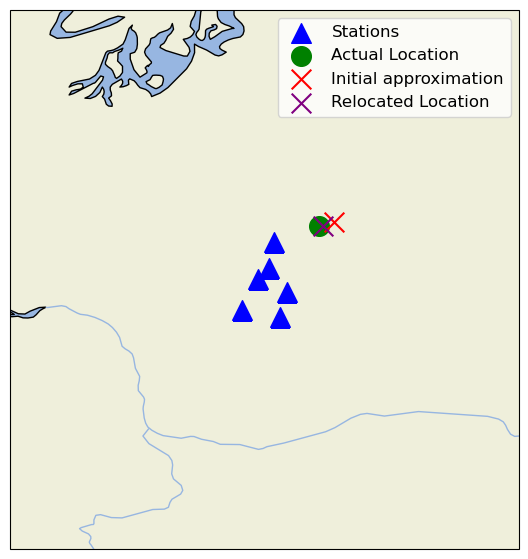

In [122]:
station_lats = predicted_df['station_latitude_deg']
station_lons = predicted_df['station_longitude_deg']

actual_lat = predicted_df['source_latitude_deg'].iloc[0]
actual_lon = predicted_df['source_longitude_deg'].iloc[0]
predicted_lat, predicted_lon = best_location

fig = plt.figure(figsize=(15, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.scatter(station_lons, station_lats, color='blue', marker='^', s=200, label='Stations')
ax.scatter(actual_lon, actual_lat, color='green', marker='o', s=200, label='Actual Location')
ax.scatter(predicted_lon, predicted_lat, color='red', marker='x', s=200, label='Initial approximation')
ax.scatter(relocated_lon, relocated_lat, color='purple', marker='x', s=200, label='Relocated Location')

plt.legend(fontsize = 'large')
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]])

plt.show()